# Walk through all steps used in research

Author: CK kibet

citation: Kibet CK and Machanick P. Transcription factor motif quality assessment requires systematic comparative analysis [version 1; referees: 2 approved with reservations]. F1000Research 2015, 4(ISCB Comm J):1429 (doi: 10.12688/f1000research.7408.1)

Feel free to email at calebkibet88@gmail.com for any clarity needed. 

#### First, lets import all the base modules

In [21]:
import os
import errno
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import random


from multiprocessing import Pool, cpu_count
import subprocess
import pandas as pd
import numpy as np
from math import  exp
import seaborn as sns
import glob
import os

import pybedtools
#import pyBigWig
import pysam
pd.set_option('display.max_colwidth', -1)


from tempfile import NamedTemporaryFile
%matplotlib inline

In [408]:
sns.set(style="white", context="poster")

figure_path = "/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter3/Figs"

### Convert the ENCODE data into posneg format

posneg is a format we just made up to represent the test file as follows: 

    chromosome:start-end score sequence eg

    chr19:10828427-10828527	486.128011369018 TCTACTGGCACGTCTGCCTGCCAATAAGAT
    
To convert to this format, the following are required:

1. A human genome file in Hg19 format that has been repeat-masked with NNs
2. MEME fastafrombed script--just get complete meme tools, you'll need them later
+ A bedwidden script from the folowing site.

A script to execute the whole process is provided.

## Extract the relevant background sequences of interest into BED files

In [658]:
tf_list = ['cebpb',
 'ctcf',
 'egr1',
 'elf1',
 'ets1',
 'foxa',
 'gata3',
 'hnf4a',
 'mafk',
 'max',
 'mef2a',
 'myb',
 'nrf1',
 'pax5',
 'pou2f2',
 'prdm1',
 'sp1',
 'srf',
 'tcf3',
 'yy1']

### Path to human genome

In [1]:
hg = "/home/kipkurui/Project/MARS/Data/hg19.fa"

In [147]:
def get_flanking_background(peak, width, downstream_distance):
    """
    Given a bed file, extract the fasta in tab format and eliminate the masked sequences,
    and extract the negative version of the file
    
    """
    #Read the narrow peak file into a pandas DataFrame
    
    peak_file = pd.read_table(peak, header=None)[[0,1,2]]
    
    size = peak_file.count()[0]
    if size/20 >500:
        use_size = size/20
    else:
        use_size = 500
    
    peak_file = peak_file.head(use_size*2)
    
    #Lets widden the coordinates to 100bp centered around the center
    mid = (peak_file[2] + peak_file[1])/2
    peak_file[1] = (mid - width/2+0.5).apply(int)
    peak_file[2]  = (mid + width/2+0.5).apply(int)
    
    #Extract the negative set located 500bp downstream
    neg_bed = peak_file.copy(deep=True)
    
    neg_bed[1] = neg_bed[1]+downstream_distance
    neg_bed[2] = neg_bed[2]+downstream_distance
    
    # Eliminate repeat masked regions from the bed file
    peak_file = remove_repeats(peak_file) #.to_csv(pos_bed_out, index=None, header=None, sep="\t")
    neg_bed = remove_repeats(neg_bed) #.to_csv(neg_bed_out, index=None, header=None, sep="\t")
    
    #hg = "/home/kipkurui/Project/MAT_server/Data/hg19.fa"
    #return peak_file, neg_bed
    
    combined_bed = peak_file.head(use_size).append(neg_bed.head(use_size))
    combined_bed.reset_index(drop=True, inplace=True)
    return combined_bed
    #pybedtools.BedTool.from_dataframe(peak_file).sequence(fi=hg,).save_seqs(negfa_out)

def remove_repeats(dfs):
    """
    Takes a bed file dataframe and eliminated bed
    coordinates that fall within the repeat masked sections
    """
    repeats = pd.read_table("/home/kipkurui/Downloads/repeat_sites.bed", header=None)
    repeats = pybedtools.BedTool.from_dataframe(repeats)
#     if len(dfs) > 2000:
#         get_top = 2000
#     else:
#         get_top = len(dfs)
    a = pybedtools.BedTool.from_dataframe(dfs)
    
    test = a.subtract(repeats, A=True)
    
    return test.to_dataframe()

## Test for effect of length

In [414]:
len_dic = {"At_50":50,"At_100":100,"At_250":250}

In [430]:
for length in "At_50 At_100 At_250".split():
    width = len_dic[length]
    
    for tf in tf_list:
        max_ch = glob.glob("/home/kipkurui/Project/MARS/Data/ChIP-seq/Downloaded/*%s*" % tf.capitalize())
        if len(max_ch) > 15:
            random.seed(10)
            max_ch = random.sample(max_ch, 15)
        for peak in max_ch:
            pybedtools.cleanup()
            combined_bed = get_flanking_background(peak, width, 500)
            #combined_bed = get_background(peak,width,neg_type)
            f_name = peak.split("/")[-1].split("wgEncodeAwgTfbs")[-1].split("UniPk.narrowPeak")[0] + ".posneg"

            save_neg = "../Length/%s/Data/%s" % (length,tf.lower())
            mkdir_p(save_neg)

            pybedtools.BedTool.from_dataframe(combined_bed).sequence(fi=hg,tab=True).save_seqs("%s/%s" % (save_neg,f_name))

## Run the analysis

In [572]:
for neg_type in ["At_250"]: #"At_50 At_250".split():#"promoter gc flanking dinuc_shuffled".split():
    for tf in tf_list:
        results_path = '../Length/%s/Results/%s' % (neg_type,tf.lower())
        mkdir_p(results_path)

        chip_seq_list = glob.glob('../Length/%s/Data/%s/*' % (neg_type,tf.lower()))
        
        for key in "gomeroccupancyscore energyscore".split():
            assess.run_all(tf, key, '%s/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

### Analysis 

In [630]:
key = "gomer"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "At_50 At_100 At_250".split():
        results_path = '../Length/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    #print combined_gomer_auc.corr().mean()
    combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
    combined_tfs_mean[tf] = combined_gomer_auc.median()

In [631]:
al_list = ["Tf At_50 At_100 At_250".split()]
sns.set(style="white", context="paper")
key = "gomer"
#combined_tfs_corr = pd.DataFrame()
#combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "At_50 At_100 At_250".split():
        results_path = '../Length/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    new_l = [tf]
    for neg_type in "At_50 At_100 At_250".split():
        #print neg_type
        #for neg in "genomic promoter gc flanking dinuc_shuffled".split():
        new_l.append(get_stat_wilcoxon_effect_size(combined_gomer_auc[neg_type],combined_gomer_auc["At_100"])[0])
    al_list.append(new_l[:])

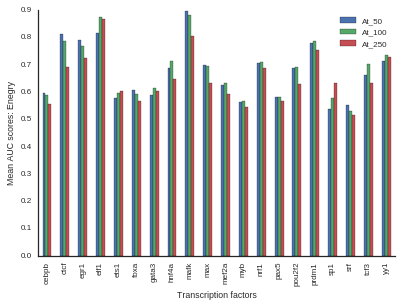

In [629]:
combined_tfs_mean.T.plot.bar()
plt.ylabel("Mean AUC scores: Enegry")
plt.xlabel("Transcription factors")
sns.despine()
plt.savefig("%s/Effect_of_length_energy_auc.pdf" % figure_path, bbox_inches='tight')

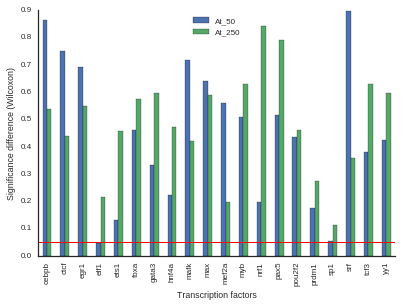

In [633]:
test = pd.DataFrame(al_list)
test.set_index(0, inplace=True)
new_header = test.iloc[0] #grab the first row for the header
test = test[1:] #take the data less the header row
test = test.rename(columns = new_header) 
del test["At_100"]

sns.set(style="white", context="paper")
test.plot.bar(stacked=False)
plt.axhline(0.05, linewidth=1, color='r')
plt.ylabel("Significance difference (Wilcoxon)")
plt.xlabel("Transcription factors")
sns.despine()
plt.savefig("%s/Effect_of_length_gomer_100_auc_wilcoxon.pdf" % figure_path, bbox_inches='tight')

In [91]:
peak = "../ChIP_seq/Data/Derived/BroadDnd41Ctcf-tmp.bed"

width = 100
neg_type = "genomic"

def get_background(peak,width,neg_type):
    """
    TODO: Ensure that it can adapt to fewer sequences gracefully
    """
    peak_file = pd.read_table(peak, header=None)[[0,1,2]]
    size = peak_file.count()[0]
    
    if size/20 >500:
        use_size = size/20
    else:
        use_size = 500
    peak_file = peak_file.head(use_size*2)
    
    mid = (peak_file[2] + peak_file[1])/2
    peak_file[1] = (mid - width/2+0.5).apply(int)
    peak_file[2]  = (mid + width/2+0.5).apply(int)

    peak_file = remove_repeats(peak_file)

    tempbed_pos = NamedTemporaryFile(dir=mytmpdir).name
    tempbed_neg_genomic = NamedTemporaryFile(dir=mytmpdir).name
    peak_file.to_csv(tempbed_pos,sep="\t",header=False, index=False)

    !gimme background -i {tempbed_pos} -f BED -l {width} -n {use_size*4} -g hg19 {tempbed_neg_genomic} {neg_type}
    
    tempbed_neg_genomic_bed = pd.read_table(tempbed_neg_genomic, header=None)[[0,1,2]]
    tempbed_neg_genomic_bed = remove_repeats(tempbed_neg_genomic_bed)
    
    combined_bed = peak_file.head(use_size).append(tempbed_neg_genomic_bed.head(use_size))
    combined_bed.reset_index(drop=True, inplace=True)
    
    os.remove(tempbed_pos)
    os.remove(tempbed_neg_genomic)
    
    return combined_bed
    

In [ ]:
def plot_raw_assess(raw_data, figure_output, stat):
    """
    This function allows the raw data to be plotted  in the form of a clustermap

    This way, information about how each motif scores in different cell lines is
    obtained
    """
    sns.set_style("white")
    raw_max = pd.read_table(raw_data)
    raw_max = raw_max.drop_duplicates()

    raw_edit = raw_max.pivot('Motif', 'Cell_lab', stat)
    raw_edit.sort(columns="Average", axis=0, ascending=False, inplace=True)
    cg = sns.clustermap(raw_edit, method='single', metric="euclidean", z_score=None,
                        annot=True, row_cluster=False, col_cluster=True, linewidths=.15)
    # to rotate the y-axis labels correctly
    test = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    test = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

    f = plt.gcf()
    #f.savefig(figure_output, bbox_inches='tight')

In [226]:
tf_list.pop(tf_list.index("ctcf"))
tf_list.pop(tf_list.index("cebpb"))

'cebpb'

In [227]:
width = 100
#neg_type = "gc"
for neg_type in ["gc"]:#.split():
    for tf in tf_list:
        max_ch = glob.glob("/home/kipkurui/Project/MARS/Data/ChIP-seq/Downloaded/*%s*" % tf.capitalize())
        for peak in max_ch:
            pybedtools.cleanup()
            combined_bed = get_background(peak,width,neg_type)
            f_name = peak.split("/")[-1].split("wgEncodeAwgTfbs")[-1].split("UniPk.narrowPeak")[0] + ".posneg"

            hg = "/home/kipkurui/Project/MARS/Data/hg19.fa"
            save_neg = "../background/%s/Data/%s" % (neg_type,tf.lower())
            mkdir_p(save_neg)

            pybedtools.BedTool.from_dataframe(combined_bed).sequence(fi=hg,tab=True).save_seqs("%s/%s" % (save_neg,f_name))

not enough random sequences found for 0.0 <= GC < 0.05 (0 instead of 3)
not enough random sequences found for 0.65 <= GC < 0.7 (982 instead of 1483)
not enough random sequences found for 0.7 <= GC < 0.75 (207 instead of 1364)
not enough random sequences found for 0.75 <= GC < 0.8 (105 instead of 1122)
not enough random sequences found for 0.8 <= GC < 0.85 (23 instead of 416)
not enough random sequences found for 0.85 <= GC < 0.9 (0 instead of 11)
not enough random sequences found for 0.65 <= GC < 0.7 (475 instead of 709)
not enough random sequences found for 0.7 <= GC < 0.75 (84 instead of 739)
not enough random sequences found for 0.75 <= GC < 0.8 (42 instead of 594)
not enough random sequences found for 0.8 <= GC < 0.85 (10 instead of 198)
not enough random sequences found for 0.85 <= GC < 0.9 (0 instead of 21)
not enough random sequences found for 0.6 <= GC < 0.65 (349 instead of 361)
not enough random sequences found for 0.65 <= GC < 0.7 (267 instead of 417)
not enough random seque

### get the normal flanking seqeunces

In [224]:
width = 100
neg_type = "flanking"
for tf in tf_list:
    max_ch = glob.glob("/home/kipkurui/Project/MARS/Data/ChIP-seq/Downloaded/*%s*" % tf.capitalize())
    for peak in max_ch:
        pybedtools.cleanup()
        combined_bed = get_flanking_background(peak, width, 500)
        #combined_bed = get_background(peak,width,neg_type)
        f_name = peak.split("/")[-1].split("wgEncodeAwgTfbs")[-1].split("UniPk.narrowPeak")[0] + ".posneg"

        hg = "/home/kipkurui/Project/MARS/Data/hg19.fa"
        save_neg = "../background/%s/Data/%s" % (neg_type,tf.lower())
        mkdir_p(save_neg)

        pybedtools.BedTool.from_dataframe(combined_bed).sequence(fi=hg,tab=True).save_seqs("%s/%s" % (save_neg,f_name))

### Shuffle sequences

In [225]:
width = 100
neg_type = "dinuc_shuffled"
for tf in tf_list:
    max_ch = glob.glob("/home/kipkurui/Project/MARS/Data/ChIP-seq/Downloaded/*%s*" % tf.capitalize())
    for peak in max_ch:
        f_name = peak.split("/")[-1].split("wgEncodeAwgTfbs")[-1].split("UniPk.narrowPeak")[0] + ".posneg"

        hg = "/home/kipkurui/Project/MARS/Data/hg19.fa"
        save_neg = "../background/%s/Data/%s" % (neg_type,tf.lower())
        mkdir_p(save_neg)

        shuffle = "../background/%s/Data/%s/%s" % (neg_type,tf.lower(),f_name)
        get_sh = "../background/%s/Data/%s/%s" % ("flanking",tf.lower(),f_name)

        tmpfasta = NamedTemporaryFile(dir=mytmpdir).name
        tmpfasta2 = NamedTemporaryFile(dir=mytmpdir).name

        a = !wc -l {get_sh} |cut -f1 -d" "
        a = (int(a[0]))/2

        !head -{a} {get_sh} >{shuffle}
        !tab2fasta.pl {get_sh} >{tmpfasta}
        !fasta-dinucleotide-shuffle -f {tmpfasta} > {tmpfasta2}
        !fasta2tab.pl {tmpfasta2} | head -{a} >>{shuffle}

        os.remove(tmpfasta)
        os.remove(tmpfasta2)



#         pybedtools.BedTool.from_dataframe(combined_bed).sequence(fi=hg,tab=True).save_seqs("%s/%s" % (save_neg,f_name))

	Found 998 sequences
	Found 3832 sequences
	Found 1807 sequences
	Found 5609 sequences
	Found 2224 sequences
	Found 3870 sequences
	Found 1554 sequences
	Found 6100 sequences
	Found 7044 sequences
	Found 1844 sequences
	Found 3698 sequences
	Found 1632 sequences
	Found 1000 sequences
	Found 1000 sequences
	Found 1800 sequences
	Found 2300 sequences
	Found 2778 sequences
	Found 1072 sequences
	Found 1000 sequences
	Found 1000 sequences
	Found 5048 sequences
	Found 984 sequences
	Found 4154 sequences
	Found 1000 sequences
	Found 4011 sequences
	Found 4298 sequences
	Found 3653 sequences
	Found 1586 sequences
	Found 968 sequences
	Found 1190 sequences
	Found 2080 sequences
	Found 1112 sequences
	Found 1398 sequences
	Found 1850 sequences
	Found 3655 sequences
	Found 1136 sequences
	Found 6045 sequences
	Found 3962 sequences
	Found 4616 sequences
	Found 1184 sequences
	Found 1112 sequences
	Found 3142 sequences
	Found 1000 sequences
	Found 1254 sequences
	Found 3464 sequences
	Found 1000 s

In [148]:
#combined_bed = get_flanking_background(peak, width, 500)

In [ ]:
# tempbed_neg_gc = NamedTemporaryFile(dir=mytmpdir).name
# !gimme background -i {tempbed_pos} -f BED -l 100 -n {size/10} -g hg19 {tempbed_neg_gc} gc
# tempbed_neg = NamedTemporaryFile(dir=mytmpdir).name
# !gimme background -i {tempbed_pos} -f BED -l 100 -n {size/10} -g hg19 {tempbed_neg_promoter} genomic

In [39]:
!cut -f1,2,3 ../ChIP_seq/Data/Derived/BroadDnd41Ctcf-tmp.bed >../ChIP_seq/Data/Derived/BroadDnd41Ctcf-tmp2.bed

#### Convert Encode to bed file

In [2]:
!cut -f1,2,3,7 ../ChIP_seq/Data/Downloaded/wgEncodeAwgTfbsBroadDnd41CtcfUniPk.narrowPeak >../ChIP_seq/Data/Derived/BroadDnd41Ctcf-tmp.bed 

#### Extract the fasta files in the posneg format.

In [3]:
genome_path = 'provide path to hg19 genome'

In [233]:
# import os
# os.system("./bed2chipseg.sh ../ChIP_seq/Data/Derived/BroadDnd41Ctcf-tmp.bed  ../ChIP_seq/Data/Derived/BroadDnd41Ctcf %s" %genome_path)

Assuming the motifs have been generated, they can be used to score the above sequences using the following scoring functions:

    1. gomeroccupnacyscore
    2. energyscore
    3. maxoccupancyscore
    4. occupancyscore
    5. occupancyscore
    6. sumlogoddsscore
    7. maxlogoddsscore
In my case, I querried a local motf database for motifs for a given TF.

#### Import the module to directly access the functions.

In [105]:
import Assess_by_score_v2 as assess

Assess_by_score_v2.py:652: SyntaxWarning: name 'g_kmer2id' is assigned to before global declaration
  global g_kmer2id


In [3]:
#import Assess_motifsdb as assess

#### Get the base directory 

In [99]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('Assess_motifsdb.py')))

For the purpose of this demo, we are going to use Ctcf motifs.

Create a results directory complete with paths using:

In [107]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [135]:
tf = 'ctcf'
results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
mkdir_p(results_path)

In [142]:
neg_type = "genomic"

## Run complete analysis for test of choice of background sequences

In [228]:
tf_list.append("ctcf")
tf_list.append("cebpb")

In [234]:
# for tf in tf_list:
#     meme = '%s/Motifs/%s.meme' %(BASE_DIR, tf)
#     !wc -l {meme}

In [657]:
assess.score_extensions

{'amaoccupancyscore': 'ama',
 'energy_score_kmer': 'energymer',
 'energyscore': 'energy',
 'gomeroccupancyscore': 'gomer',
 'kmersvm_score_seq': 'kmersvm',
 'max_score_kmer': 'max_kmer',
 'max_score_kmer_pos': 'max_kmer_pos',
 'maxlogoddsscore': 'maxlog',
 'maxoccupancyscore': 'maxoc',
 'sumlogoddsscore': 'sumlog',
 'sumoccupancyscore': 'sumoc'}

In [659]:
for neg_type in ["flanking"]:#"promoter gc flanking dinuc_shuffled".split():
    for tf in tf_list:#["ctcf","cebpb"]:
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        mkdir_p(results_path)

        chip_seq_list = glob.glob('../background/%s/Data/%s/*' % (neg_type,tf.lower()))
        
        for key in "sumoccupancyscore maxlogoddsscore maxoccupancyscore sumlogoddsscore amaoccupancyscore".split():
            assess.run_all(tf, key, '%s/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

### Data analysis

In [ ]:
for neg_type in ["genomic promoter gc flanking dinuc_shuffled".split():
    for tf in ["ctcf","cebpb"]:
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        mkdir_p(results_path)

        chip_seq_list = glob.glob('../background/%s/Data/%s/*' % (neg_type,tf.lower()))
        
        for key in "gomeroccupancyscore energyscore".split():
            assess.run_all(tf, key, '%s/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

In [305]:
#combined_tfs.corr(method='spearman')

In [292]:
combined_tfs.T.mean()

genomic           0.896703
promoter          0.847235
gc                0.864448
flanking          0.922649
dinuc_shuffled    0.891795
dtype: float64

In [402]:
key = "gomer"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    #print combined_gomer_auc.corr().mean()
    combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
    combined_tfs_mean[tf] = combined_gomer_auc.median()

In [421]:
combined_tfs_mean

,cebpb,ctcf,egr1,elf1,ets1,foxa,gata3,hnf4a,mafk,max,mef2a,myb,nrf1,pax5,pou2f2,prdm1,sp1,srf,tcf3,yy1
genomic,0.657350,0.730576,0.754618,0.849364,0.683818,0.691864,0.626062,0.729545,0.747118,0.73456,0.698115,0.605222,0.745727,0.626577,0.658957,0.768778,0.71770,0.618483,0.666053,0.739409
promoter,0.643300,0.677636,0.672324,0.762364,0.572977,0.690136,0.627594,0.679705,0.726471,0.68284,0.749231,0.554556,0.694773,0.571538,0.658174,0.752056,0.54225,0.583448,0.661158,0.661727
gc,0.608350,0.688212,0.705735,0.802682,0.600909,0.639636,0.562156,0.687114,0.732118,0.67640,0.588769,0.550889,0.720727,0.586923,0.621739,0.738833,0.65130,0.569931,0.606737,0.689455
flanking,0.625125,0.685939,0.684824,0.788045,0.583864,0.654000,0.577219,0.677636,0.724000,0.68680,0.663692,0.550778,0.713182,0.583077,0.640043,0.742278,0.58500,0.580172,0.634947,0.678091
dinuc_shuffled,0.609625,0.666970,0.652059,0.769500,0.585295,0.661455,0.569844,0.655773,0.726941,0.66356,0.668115,0.510222,0.714273,0.573500,0.652261,0.749167,0.60230,0.583276,0.637158,0.664136


In [455]:
def get_stat_wilcoxon_effect_size(sample1,sample2):
    X1 = np.array(sample1)
    X2 = np.array(sample2)
    n1 = len(sample1)
    n2 = len(sample2)
    m1 = np.mean(X1)
    m2 = np.mean(X2)
    s1 = np.std(X1,ddof=1)
    s2 = np.std(X2,ddof=1)

    s = np.sqrt( ((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2) )
    return ranksums(sample1,sample2)[1],(m2-m1)/s

In [465]:
get_stat_wilcoxon_effect_size(combined_gomer_auc["genomic"],combined_gomer_auc["flanking"])

(0.095602630620163012, -0.38194667590066134)

### Calculating the significance differece in the ranks in different background sequences

In [596]:
al_list = ["Tf genomic promoter gc flanking dinuc_shuffled".split()]
sns.set(style="white", context="paper")
key = "gomer"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    new_l = [tf]
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        #print neg_type
        #for neg in "genomic promoter gc flanking dinuc_shuffled".split():
        new_l.append(get_stat_wilcoxon_effect_size(combined_gomer_auc[neg_type],combined_gomer_auc["genomic"])[0])
    al_list.append(new_l[:])
    
    #print combined_gomer_auc.corr().mean()
    #combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
    #combined_tfs_mean[tf] = combined_gomer_auc.mean()

In [597]:
test = pd.DataFrame(al_list)
test.set_index(0, inplace=True)
new_header = test.iloc[0] #grab the first row for the header
test = test[1:] #take the data less the header row
test = test.rename(columns = new_header) 
del test["genomic"]

In [592]:
test

,promoter,gc,flanking,dinuc_shuffled
0,,,,
cebpb,0.00182274,0.00656069,0.0020095,0.00977631
ctcf,0.0528072,0.0273974,0.0283086,0.188675
egr1,0.2777,0.0121312,0.206463,0.936455
elf1,0.00982327,0.00266021,0.00856529,0.043524
ets1,0.34354,0.0380968,0.200191,0.18454
foxa,0.010512,0.0183243,0.00602721,0.0033454
gata3,1.13463e-07,1.89813e-05,7.00658e-08,1.29746e-08
hnf4a,0.00156219,0.00409448,0.00702751,0.0470127
mafk,0.0371753,0.0313406,0.0125194,0.0113544


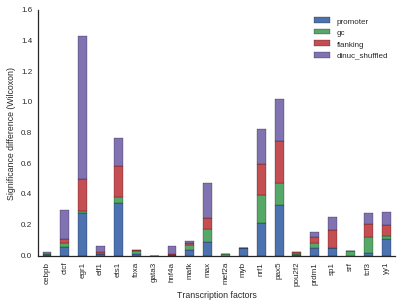

In [586]:
test.plot.bar(stacked=True)
plt.ylabel("Significance difference (Wilcoxon)")
plt.xlabel("Transcription factors")
sns.despine()
#plt.savefig("%s/effect_of_background_gomer_wilcoxon_genomic_auc.pdf" % (figure_path), bbox_inches='tight')

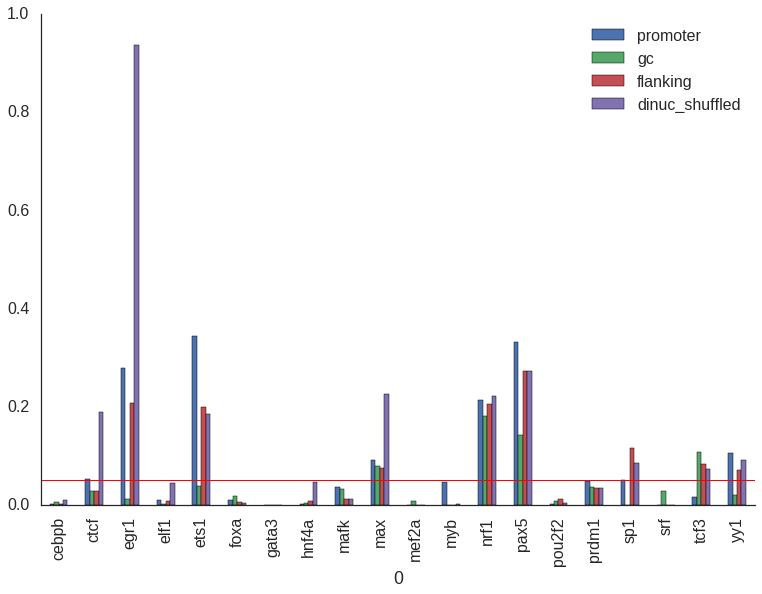

In [587]:
# sns.set(style="white", context="paper")
# test.plot.bar(stacked=False)
# plt.axhline(0.05, linewidth=1, color='r')
# sns.despine()

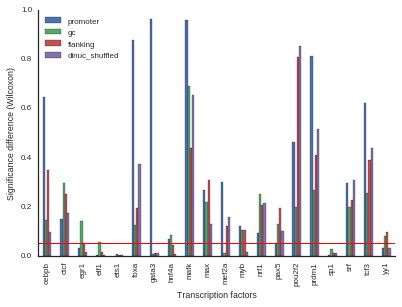

In [598]:
sns.set(style="white", context="paper")
test.plot.bar(stacked=False)
plt.axhline(0.05, linewidth=1, color='r')
plt.ylabel("Significance difference (Wilcoxon)")
plt.xlabel("Transcription factors")
sns.despine()
plt.savefig("%s/effect_of_background_gomer_wilcoxon_genomic_auc_bar.pdf" % (figure_path), bbox_inches='tight')

In [463]:
get_stat_wilcoxon_effect_size(combined_tfs_corr.T["genomic"],combined_tfs_corr.T["flanking"])

(0.10458826282895559, 0.44069471736884486)

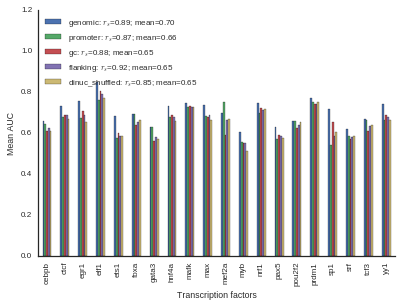

In [451]:
sns.set(style="white", context="paper")
key = "gomer"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    #print combined_gomer_auc.corr().mean()
    combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
    combined_tfs_mean[tf] = combined_gomer_auc.mean()


fig, ax1 = plt.subplots()
axes = combined_tfs_mean.T.plot.bar(ax=ax1)
ave_additive = combined_tfs_corr.T.mean()
ave_additive2 = combined_tfs_mean.T.mean()
leg = list(combined_tfs_mean.T.columns)


new_leg = []
for i in leg:
    new_leg.append("%s: $r_s$=%.2f; mean=%.2f" % (i,ave_additive[i], ave_additive2[i]))
plt.ylim(ymax=1.2)
plt.ylabel("Mean AUC")
plt.xlabel("Transcription factors")
axes.legend(new_leg,loc='upper left')
sns.despine()
fig.savefig("%s/effect_of_background_gomer_mean_auc.pdf" % (figure_path), bbox_inches='tight')

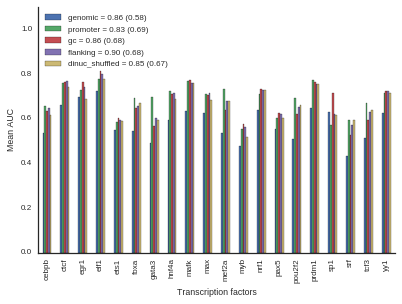

In [450]:
sns.set(style="white", context="paper")
key = "energy"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    #print combined_gomer_auc.corr().mean()
    combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
    combined_tfs_mean[tf] = combined_gomer_auc.mean()


fig, ax1 = plt.subplots()
axes = combined_tfs_mean.T.plot.bar(ax=ax1)
ave_additive = combined_tfs_corr.T.mean()
ave_additive2 = combined_tfs_mean.T.mean()
leg = list(combined_tfs_mean.T.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.2f (%.2f)" % (i,ave_additive[i], ave_additive2[i]))
plt.ylim(ymax=1.1)
plt.ylabel("Mean AUC")
plt.xlabel("Transcription factors")
axes.legend(new_leg,loc='upper left')
sns.despine()
fig.savefig("%s/effect_of_background_energy_mean_auc.pdf" % (figure_path), bbox_inches='tight')

In [241]:
score_key = ['energy', 'gomer']
neg_type = "genomic"
stat = 'AUC'
for tf in {"ctcf"}:
    results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
    #results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    raw_data = []
    raw_data.append(["Motif"])
    flag = 0
    for key in score_key:
        i = 1
        raw_data[0].append(key)
        with open('%s/%s.%s' % (results_path,tf,key)) as score_out:
            for line in score_out:
                if line.split()[1]=="AUC":
                    continue
                else:
                    if flag ==0:
                        raw_data.append([line.split()[0]])
                        raw_data[i].append(line.split()[4])
                        i+=1
                    else:
                        raw_data[i].append(line.split()[4])
                        i+=1
            flag = 1
        with open("%s/%s_%s.rawscores" %(results_path,tf, stat), 'w') as raw_out:
            for row in raw_data:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')

With the Results folder for Ctcf in place, the next this in to get a list of all the ChIP-seq data convered as shown above to posneg format. We use the function below. 

In [109]:
import glob
chip_seq_list = glob.glob('%s/ChIP_seq/Data/Derived/%s/*' % (BASE_DIR, tf))

We use gomeroccupancy score for this demo, but a quick run for all the motifs can be run by looping though all the scoring functions as follows:

In [10]:
#for key in assess.score_extensions:
    #assess.run_all(tf, key, '%s/Data/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

Uncomment the above cell for a quick run of all the scoring functions. Internally, the program chooses 10 random sequences, in a situation where more than 10 are available. We observed no better discrimination from more data, just takes lots of time. 

In [238]:
# key = 'energyscore'
# assess.run_all(tf, key, '%s/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

### Combining the above steps to loop through multiple TFs and scoring functions

In [13]:
#tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
tf_list = ['ctcf']
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    
    #make results path
    mkdir_p(results_path)
    
    #Exract the available ChIP-seq list
    chip_seq_list = glob.glob('%s/ChIP_seq/Data/Derived/%s/*' % (BASE_DIR, tf))
    
    test_meme_input = '%s/ChIP_seq/Data/Motifs/%s.meme' %(BASE_DIR, tf)
    
    for key in assess.score_extensions:
        assess.run_all(tf, key, test_meme_input, chip_seq_list, results_path)

## Run analysis using CentriMo

For motif enrichment analsys, a *run_centrimo* module is provided. This requires that the The MEME Suite tools version 4.10.0, which can be intsalled from <a href='http://meme-suite.org/doc/download.html?man_type=web'>MEME-Suite</a>.

The steps followed are similar as above:

In [14]:
import run_centrimo

In [15]:
tf_list = "esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = ['sp1']
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    
    #make results path
    mkdir_p(results_path)
    
    #Exract the available ChIP-seq list
    chip_seq_list = glob.glob('%s/ChIP_seq/Data/Derived/%s/*' % (BASE_DIR, tf))
    
    #meme file with motifs to determine enrichment
    test_meme_input = '%s/ChIP_seq/Data/Motifs/%s.meme' %(BASE_DIR, tf)
    
    #Run the cmplete pipeline
    run_centrimo.run_centrimo(tf, chip_seq_list, test_meme_input, results_path)

## Paper figures and tables

The above steps will only get up as far as obtaining the raw initial results. The steps that follow, outlines how the data was further processed and plotted. 

In [75]:
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

score_key = ['energy', 'gomer','sumlog', 'sumoc','maxoc', 'ama', 'maxlog']
stat = 'spearman'
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    raw_data = []
    raw_data.append(["Motif"])
    flag = 0
    for key in score_key:
        i = 1
        raw_data[0].append(key)
        with open('%s/%s.%s' % (results_path,tf,key)) as score_out:
            for line in score_out:
                if line.split()[1]=="AUC":
                    continue
                else:
                    if flag ==0:
                        raw_data.append([line.split()[0]])
                        raw_data[i].append(line.split()[4])
                        i+=1
                    else:
                        raw_data[i].append(line.split()[4])
                        i+=1
            flag = 1
        with open("%s/%s_%s.rawscores" %(results_path,tf, stat), 'w') as raw_out:
            for row in raw_data:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')

In [ ]:
#tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

score_key = ['energy', 'gomer']
stat = 'spearman'
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    raw_data = []
    raw_data.append(["Motif"])
    flag = 0
    for key in score_key:
        i = 1
        raw_data[0].append(key)
        with open('%s/%s.%s' % (results_path,tf,key)) as score_out:
            for line in score_out:
                if line.split()[1]=="AUC":
                    continue
                else:
                    if flag ==0:
                        raw_data.append([line.split()[0]])
                        raw_data[i].append(line.split()[4])
                        i+=1
                    else:
                        raw_data[i].append(line.split()[4])
                        i+=1
            flag = 1
        with open("%s/%s_%s.rawscores" %(results_path,tf, stat), 'w') as raw_out:
            for row in raw_data:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')

#### MOTIF INFORMATION CONTENT AND LENGTH

Summarize the motifs' information content, length as well as their scores. This is used to determine the level of correlation between the motif chracter and the scores asigned. This helps understand how IC and motif length affect the score asigned by various scores.

In [4]:
#!/usr/bin/python
from __future__ import print_function
import sys
from math import log
import os

def mot_summary(motif_file, raw_scores, out_file):
    '''
    Summary of motif and score
    '''
    found = 0
    row = 0
    n_rows = 0
    entropy = 0
    total_entropy = 0
    motifs = 0
    name = ""
    raw_dict = {}
    with open(out_file, "w") as write_out:

        with open(raw_scores) as raw_in:
            for line in raw_in:
                raw_dict[line.split()[0]] = line.split()[1:]
        out = "Motif_name\tMotif_IC\tAverage_IC\tMotif_length\t%s\t%s\t%s\t%s\n" % \
              (raw_dict["Motif"][0], raw_dict["Motif"][1], raw_dict["Motif"][2], raw_dict["Motif"][3])

        write_out.write(out)
        with open(motif_file, "r") as motif_file:
            for line in motif_file:
                words = line.split()
                if found == 0:
                    if line.startswith("MOTIF"):
                        # allow for motifs without an alternative name
                        if len(words) < 3:
                            words.append("")
                        name = (words[1])
                        found = 1
                        motifs += motifs
                        entropy = 0
                        continue
                if found == 1:
                    if line.startswith("letter-probability"):
                        n_rows = int((line.split("w="))[1].split()[0])
                        found = 2
                    continue
                if found == 2:
                    if line == "\n":
                        continue
                    else:
                        check = 0
                    for val in words:
                        if float(val) > 0:
                            check += float(val) * log(float(val))/log(2.0)
                            entropy += float(val) * log(float(val))/log(2.0)
                    row += 1
                    if row >= n_rows:
                        v = 2*n_rows+entropy
                        out = '%s\t%f\t%f\t%i\t%f\t%f\t%f\t%f\n'\
                              % (name, v, (v/n_rows), n_rows, float(raw_dict[name][0]), float(raw_dict[name][1]),
                                 float(raw_dict[name][2]), float(raw_dict[name][3]))
                        write_out.write(out)
                        #n+= 1
                        #print(n)
                        found = 0
                        row = 0
                        total_entropy += (v/n_rows)

In [29]:
statistics = ['auc','mncp']
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
for stat in statistics:
    for tf in tf_list:
        meme_file = '%s/Motifs/%s.meme' %(BASE_DIR, tf)
        results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
        test = mot_summary(meme_file,"%s/%s_%s.rawscores" % (results_path, tf, stat), "%s/%s_%s_score_ic.txt" % (results_path, tf, stat))

In [19]:
tf = 'ctcf'
results_path = '%s/Results/%s' % (BASE_DIR, tf)


# Code to reproduce figures used in the paper

### Figure1_Timelines

In [191]:
class Caption():
    def __init__(self,s):
        self.s = s
    def _repr_html_(self):
        return '<center>{0}</center>'.format(self.s)
    def _repr_latex_(self):
        return '\\begin{center}\n'+self.s+'\n\\end{center}'

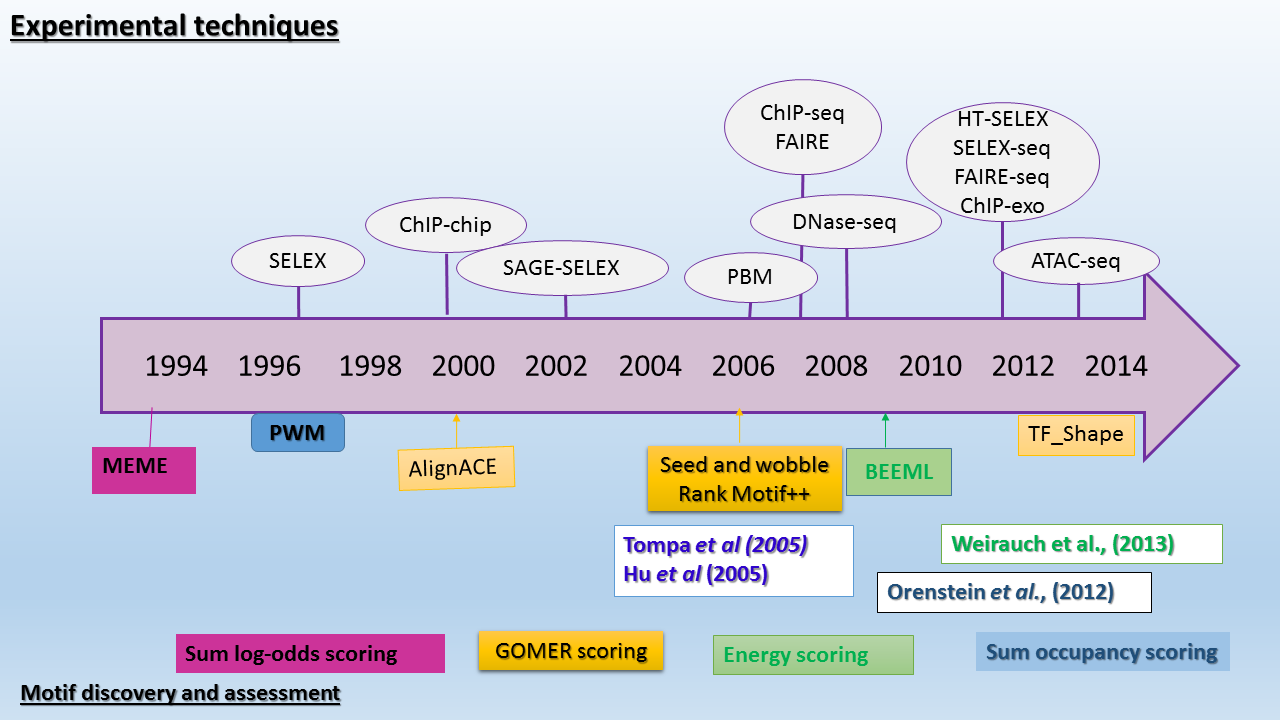

<__main__.Caption instance at 0x7f99097f2fc8>

In [213]:
from IPython.display import Image, display
test_display = """Figure 1: Evolution of motif scoring functions with experimental techniques and algorithms""" 
display(Image(filename='../Figures/Figure1_Timelines.png', embed=True, width=900), Caption(test_display))

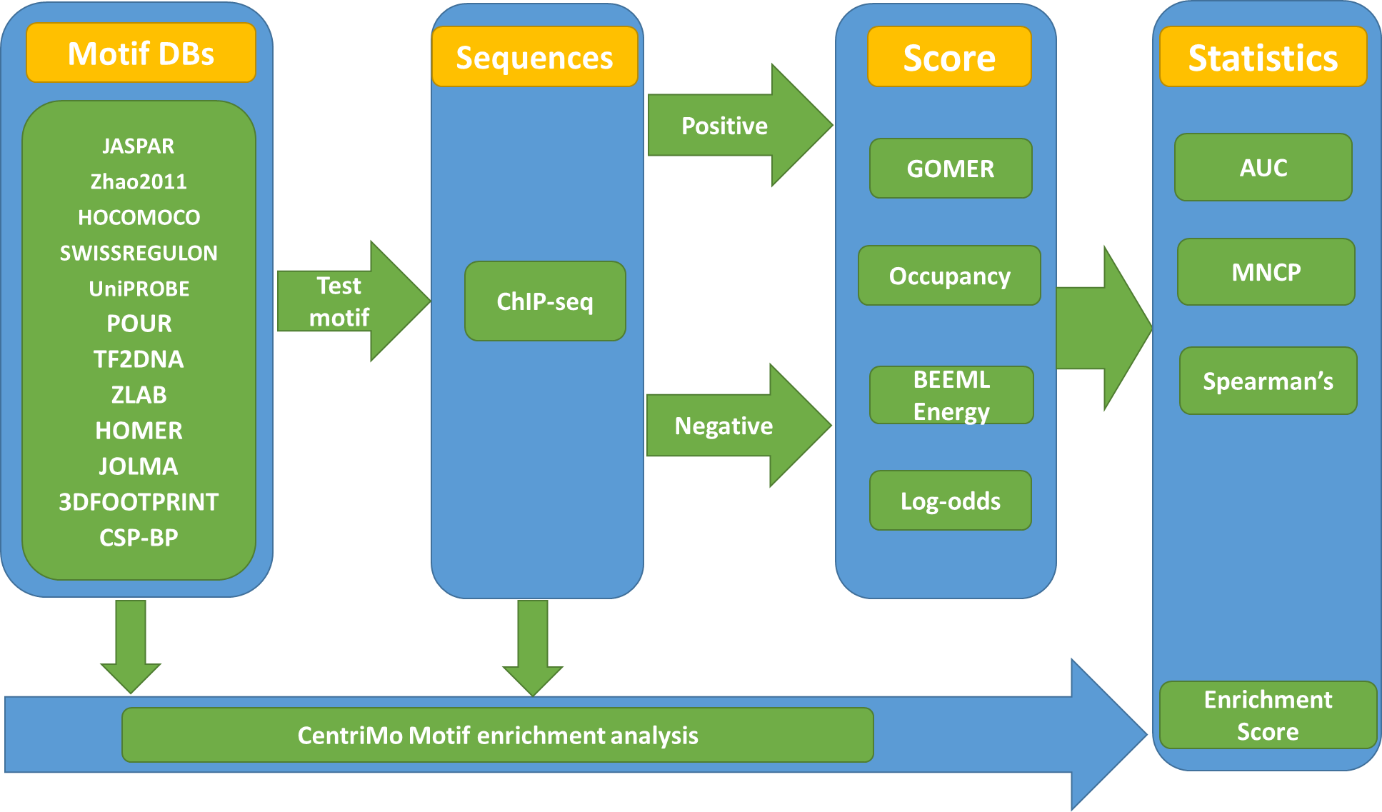

In [21]:
from IPython.display import Image
Image(filename='../Figures/Figure2_Methodology.png', embed=True, width=900) 

### Figure3_sequence_length

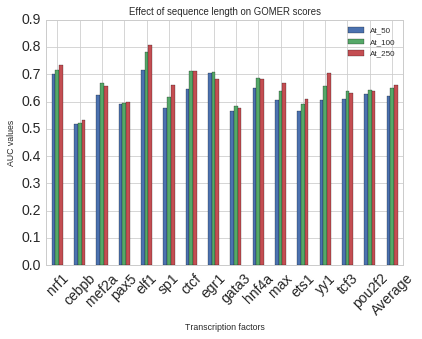

In [11]:
tf_list = ['nrf1', 'cebpb', 'mef2a', 'pax5', 'elf1','sp1','ctcf', "egr1",
           "gata3", "hnf4a", "max", "ets1", 'yy1', 'tcf3', 'pou2f2']
Av_scores = pd.DataFrame(columns=["At_50","At_100","At_250"] )
for tf in tf_list:
    raw_scores = pd.read_table('../ChIP_seq/Results/%s/%s_auc.len' %(tf,tf), header=0, index_col="Motif")

    test = raw_scores.mean().T
    
    con = test.to_frame(name=tf).T
    
    Av_scores = Av_scores.append(con)
av = Av_scores.mean(axis=0)
con = av.to_frame(name='Average').T
Av_scores = Av_scores.append(con).T

ax =Av_scores.T.plot(kind='bar',
                     title="Effect of sequence length on GOMER scores", fontsize=14, rot=45)
#ax.grid(False)
ax.set_xlabel("Transcription factors")
ax.set_ylabel("AUC values")
#ax.set_axis_bgcolor('w')
fig = ax.get_figure()
#fig.savefig('../Figures/Figure3_sequence_length.pdf')

#### Computing significance in the difference among the sequence lengths. 

In [24]:
for seq_len1 in ["At_50","At_100","At_250"]:
    for seq_len2 in ["At_50","At_100","At_250"]:
        print seq_len1, seq_len2
        print ranksums(Av_scores.T[seq_len1],Av_scores.T[seq_len2])[1]

At_50 At_50
1.0
At_50 At_100
0.113436380836
At_50 At_250
0.0545887955048
At_100 At_50
0.113436380836
At_100 At_100
1.0
At_100 At_250
0.678450783738
At_250 At_50
0.0545887955048
At_250 At_100
0.678450783738
At_250 At_250
1.0


### Figure4_cell_line_specific

/home/kipkurui/anaconda2/envs/MAT_server/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


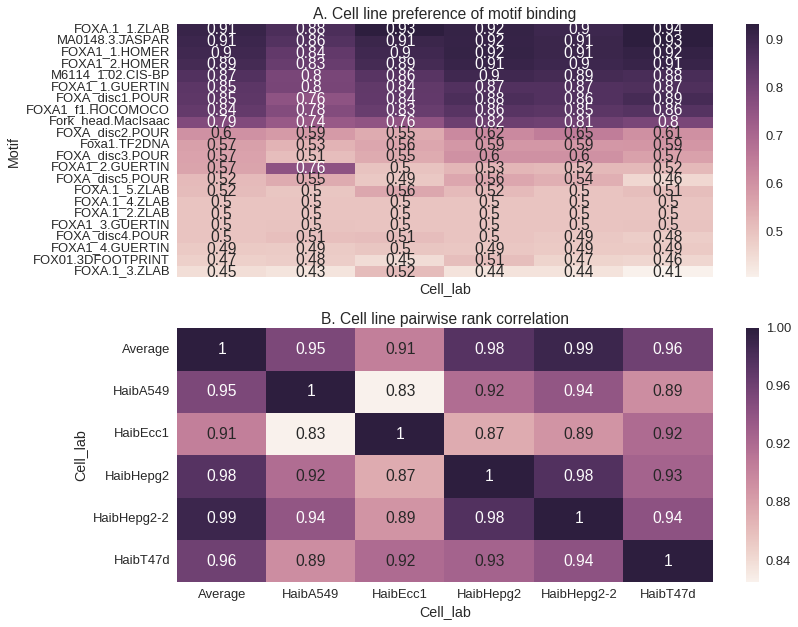

In [9]:
def plot_raw_assess(raw_data, figure_output, stat):
    """
    This function allows the raw data to be plotted  in the form of a heatmap.
    
    This way, information about how each motif scores in different cell lines is
    obtained
    """
    #Increase the font
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
    sns.set(font_scale=1.3)
    #sns.set_style("white")
    raw_max = pd.read_table(raw_data)
    raw_max = raw_max.drop_duplicates()
    
    raw_edit = raw_max.pivot('Motif', 'Cell_lab', stat)
    raw_edit.sort(columns="Average", axis=0, ascending=False, inplace=True)
    #fig, ax = plt.subplots()
    ax1.set_title('A. Cell line preference of motif binding')
    ax2.set_title('B. Cell line pairwise rank correlation')
    # the size of A4 paper
    #fig.set_size_inches(11, 8)
    sns.heatmap(raw_edit, annot=True, ax = ax1)
    sns.heatmap(raw_edit.corr(method='spearman'), ax = ax2, annot=True)
    f = plt.gcf()
    #f.savefig(figure_output, bbox_inches='tight')
    return raw_edit

raw_edit = plot_raw_assess("../ChIP_seq/Results/foxa/foxa_raw.gomer", 
                           '../Figures/Figure4_cell_line_specific_gomer.pdf', 'AUC')

## Figure 5...Effect of statistics on motif ranking

May need to expand the data, but later. 

In [41]:
?sns.set(font='times')

In [48]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("poster")
    
    # Set the font to be serif, rather than sans
    sns.set(font='times')
    #sns.set_style(despine=True)
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "times",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    #sns.set(despine=True)

In [49]:
set_style()
combined_tfs_corr = pd.DataFrame()
combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()

In [25]:
figure_path = "/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter3/Figs"

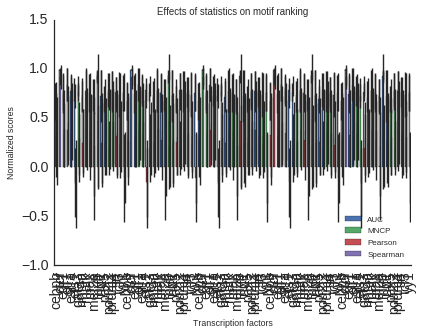

In [656]:

score = 'gomer'
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 srf tcf3 yy1".split()

# tf = 'cebpb'
# chip = pd.read_table('../ChIP_seq/Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
# chip = chip/chip.max()
# chip_std = chip.std().to_frame(name=tf).T
# chip_mean = np.mean(chip).to_frame(name=tf)
# chip_mean_test = chip_mean.T
# rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test
combined_tfs_corr = pd.DataFrame()
for tf in tf_list:
    chip = pd.read_table('../ChIP_seq/Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    #print tf
    rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
    chip_s = chip.std().to_frame(name=tf)
    chip_std = chip_std.append(chip_s.T)
    chip_mean = np.mean(chip).to_frame(name=tf)
    combined_tfs_corr[tf] = chip.corr(method="spearman").median()
    chip_mean_test = chip_mean_test.append(chip_mean.T)

ax = chip_mean_test.plot(kind='bar',yerr=chip_std,
                  title="Effects of statistics on motif ranking", fontsize=14)
#ax.grid(False)
sns.despine()
ax.set_xlabel("Transcription factors")
ax.set_ylabel("Normalized scores")
ax.set_axis_bgcolor('W')
fig = ax.get_figure()
#fig.savefig('%s/Figure5_score_and_statistic_new.pdf' % figure_path, bbox_inches="tight")
#fig.savefig('../Figures/Figure5_score_and_statistic_new.pdf')


In [655]:
rank_sum

71.717598434933606

In [ ]:
al_list = ["Tf genomic promoter gc flanking dinuc_shuffled".split()]
sns.set(style="white", context="paper")
key = "gomer"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    new_l = [tf]
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        #print neg_type
        #for neg in "genomic promoter gc flanking dinuc_shuffled".split():
        new_l.append(get_stat_wilcoxon_effect_size(combined_gomer_auc[neg_type],combined_gomer_auc["genomic"])[0])
    al_list.append(new_l[:])

In [648]:
chip.corr(method="spearman").median()

AUC         0.228245
MNCP        0.309975
Pearson     0.297027
Spearman    0.316756
dtype: float64

In [652]:
for stat in list(combined_tfs_corr.T.columns):
    

['AUC', 'MNCP', 'Pearson', 'Spearman']

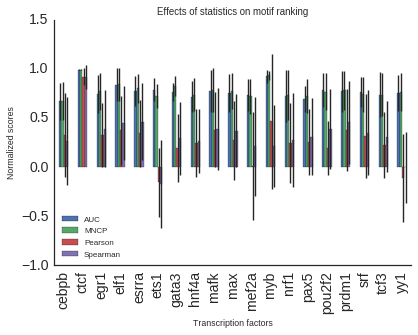

In [634]:

score = 'gomer'
tf_list = "ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 srf tcf3 yy1".split()

tf = 'cebpb'
chip = pd.read_table('../ChIP_seq/Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
chip = chip/chip.max()
chip_std = chip.std().to_frame(name=tf).T
chip_mean = np.mean(chip).to_frame(name=tf)
chip_mean_test = chip_mean.T
rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test

for tf in tf_list:
    chip = pd.read_table('../ChIP_seq/Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    #print tf
    rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
    chip_s = chip.std().to_frame(name=tf)
    chip_std = chip_std.append(chip_s.T)
    chip_mean = np.mean(chip).to_frame(name=tf)
    
    chip_mean_test = chip_mean_test.append(chip_mean.T)
ax = chip_mean_test.plot(kind='bar',yerr=chip_std,
                  title="Effects of statistics on motif ranking", fontsize=14)
#ax.grid(False)
sns.despine()
ax.set_xlabel("Transcription factors")
ax.set_ylabel("Normalized scores")
ax.set_axis_bgcolor('W')
fig = ax.get_figure()
#fig.savefig('%s/Figure5_score_and_statistic_new.pdf' % figure_path, bbox_inches="tight")
#fig.savefig('../Figures/Figure5_score_and_statistic_new.pdf')


In [653]:
rank_sum

1.2749537550619472

In [87]:
rank_sum/20

0.002231100386339958

In the figure above the spread of the scores depending on the statistic, as measured by the eror bars, shows how unreliable the use of correlation statistics to rank the motfs would be.

## Figure 6: Effect of the choice of negative sequence on motif scoring

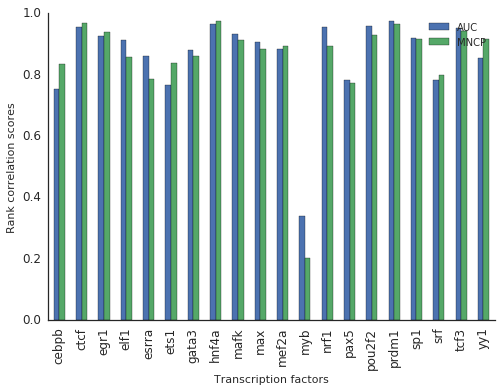

In [54]:

tf_list = "ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
score = 'gomer'
tf = 'cebpb'
chip = pd.read_table('%s/ChIP_seq/Results/%s/%s.%s' 
                     % (BASE_DIR, tf, tf, score), index_col='Motif')
dinuc = pd.read_table('%s/Dinuc_shuffled/Results/%s/%s.%s' % (BASE_DIR, tf.capitalize(), tf, score), index_col='Motif')

ran_corr = ranksums(chip['MNCP'], dinuc['MNCP'])[1] #Determine how significantly different the scores are
chip_rank = chip.rank(ascending=False)
dinuc_rank = dinuc.rank(ascending=False)
chip = chip/chip.max()
chip_mean = np.mean(chip).to_frame(name=tf)
chip_mean_test = chip_mean.T

a = dinuc_rank.corrwith(chip_rank)
a = a.to_frame(name=tf).T
for tf in tf_list:
    chip = pd.read_table('%s/ChIP_seq/Results/%s/%s.%s'
                         % (BASE_DIR, tf, tf, score), index_col='Motif')
    dinuc = pd.read_table('%s/Dinuc_shuffled/Results/%s/%s.%s' 
                          % (BASE_DIR, tf.capitalize(), tf, score), index_col='Motif')
    ran_corr += ranksums(chip['MNCP'], dinuc['MNCP'])[1]
    chip = chip/chip.max()
    chip_mean = np.mean(chip).to_frame(name=tf)

    dinuc = dinuc/dinuc.max()
    
    chip_rank = chip.rank(ascending=False)
    dinuc_rank = dinuc.rank(ascending=False)
    b = dinuc_rank.corrwith(chip_rank)
    b = b.to_frame(name=tf).T
    a = a.append(b)
    chip_mean_test = chip_mean_test.append(chip_mean.T)
#chip_mean_test.plot(kind='bar', figsize=(10,10), title="Effects of statistics on motif ranking", fontsize=14, rot=45)
#title="Rank correlation between downstream and dinucleotide negative sequences"
del a['Spearman']
del a['Pearson']
ax = a.plot(kind='bar', fontsize=12)
ax.set_xlabel("Transcription factors")
ax.set_ylabel("Rank correlation scores")
ax.set_axis_bgcolor('W')
sns.despine()
fig = ax.get_figure()
fig.savefig('%s/Figure10_effect_negative_sequences.pdf' % figure_path, bbox_inches='tight')
#fig.savefig('../Figures/Figure10_effect_negative_sequences.pdf', bbox_inches='tight')

We observe the choice of negative sequences to have little effect on the ranks assigned to the motifs. In the figure above, we computed and plotted the rank correlation of scores normalized by maximum score for each TF. However some TFs seem to be affected most by this. This generally seems to affect motifs with indirect (Myb) of flanking site binding (Tcf3)

In [93]:
auc =ran_corr/20
auc =(0.45913029381266385 + 0.50887947936999434)/2

### Figure7_effect_of_scoring_auc

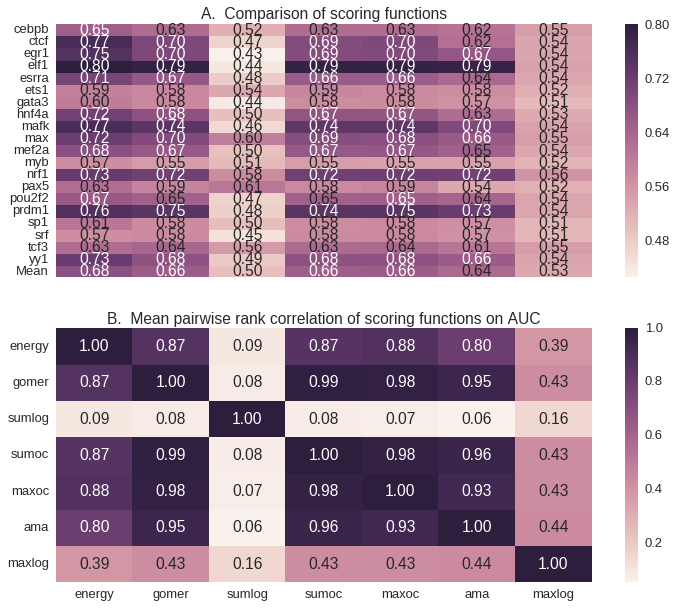

In [8]:
stat='auc'
tf_list="cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
#fig, ax = plt.subplots()
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("A.  Comparison of scoring functions")



tf = 'ctcf'
stat = 'auc'
mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list ="cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "gata3 hnf4a mafk max myb pou2f2 tcf3".split()
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on AUC")
f=plt.gcf()
f.savefig('../Figures/Figure6_effect_of_scoring_auc_new.png', bbox_inches='tight')

#### Table S1: Determine the significance of the difference between the AUC values of the various scoring functions using Wilcoxon rank-sum statistic 

**NB**: This should only be run after the above section to generate the score_sum dataframe

In [29]:
scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
ans = []
#ans.append(scores)
i = 0
for score1 in scores:
    ans.append([score1])
    for score2 in scores:
        ans[i].append(ranksums(score_sum[score1],score_sum[score2])[1])
    i+=1
scores = "Scoring_function energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
pvalues = pd.DataFrame(ans, columns=scores)     

#Save to csv file
pvalues.to_csv('../Supplementary_Tables/Table_S1.csv')

### Figure8_effect_of_scoring_mncp

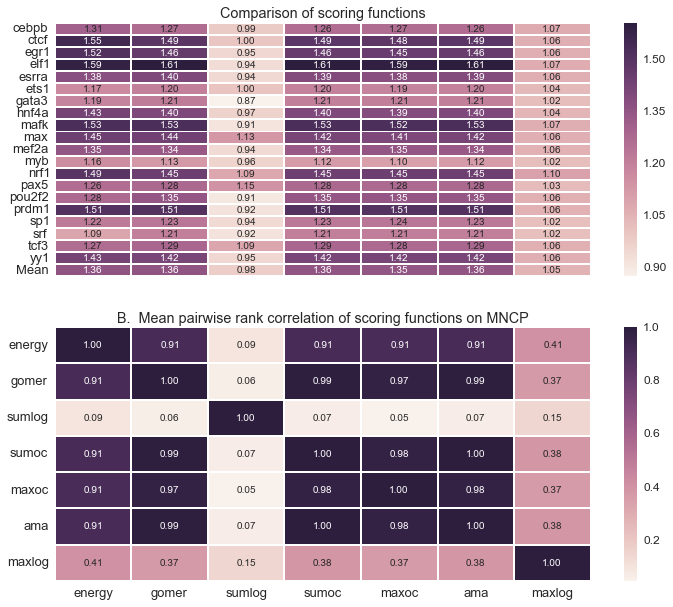

In [13]:
stat='mncp'
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#fig, ax = plt.subplots()

sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc  ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("Comparison of scoring functions")

tf = 'ctcf'
stat = 'mncp'
mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list = "cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on MNCP")
#f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc.pdf', bbox_inches='tight')
f=plt.gcf()
f.savefig('../Figures/Figure7_effect_of_scoring_mncp_new.pdf', bbox_inches='tight')

#### Table S2: Determine the significance of the difference between the MNCP values of the various scoring functions using Wilcoxon rank-sum statistic 

**NB**: This should only be run after the above section to generate the score_sum dataframe

In [31]:
from scipy.stats import ranksums
scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
ans = []
#ans.append(scores)
i = 0
for score1 in scores:
    ans.append([score1])
    for score2 in scores:
        ans[i].append(ranksums(score_sum[score1],score_sum[score2])[1])
    i+=1
scores = "Scoring_function energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
pvalues = pd.DataFrame(ans, columns=scores)     

#Save to csv file
pvalues.to_csv('../Supplementary_Tables/Table_S2.csv')

### Figure9_motif_length_ic_effect

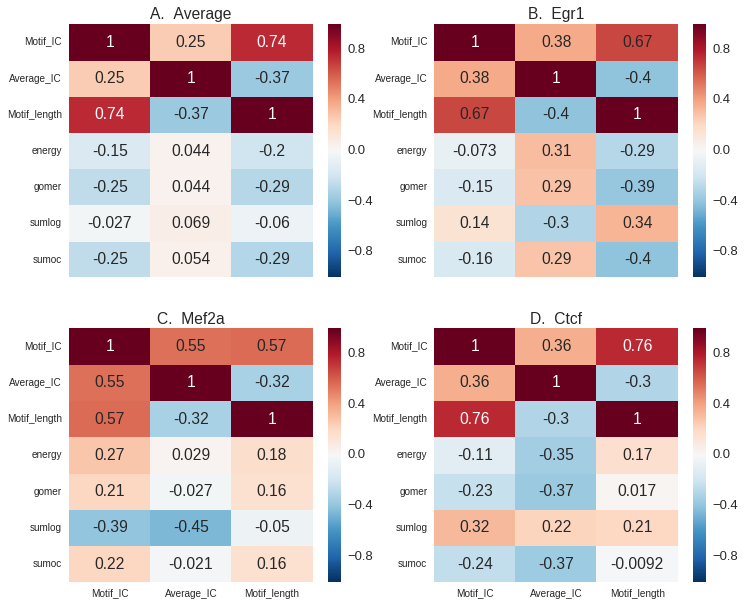

In [8]:
tf ='egr1' #initialize
stat = 'auc'
tf_list = "cebpb ctcf elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

tf_path = "%s/ChIP_seq/Results/%s" % (BASE_DIR,tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
score_ic = df.corr()

for tf in tf_list:
    tf_path = "%s/ChIP_seq/Results/%s" % (BASE_DIR,tf)
    #df = tf+"_df"
    df1 = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf,stat), index_col="Motif_name")
    score_ic2 = df1.corr()
    score_ic = score_ic.add(score_ic2, fill_value=0)
test = score_ic/(len(tf_list)+1)

del test['energy']
del test['gomer']
del test['sumlog']
del test['sumoc']

test = test


path = "%s/ChIP_seq/Results" % BASE_DIR

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=False)
sns.set(font_scale=1.3)
sns.heatmap(test, annot=True, ax = ax1)
ax1.set_title("A.  Average")

tf = "egr1"
tf_path = "%s/%s" % (path, tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax2)
ax2.set_title('B.  '+tf.capitalize())

tf = "mef2a"
tf_path = "%s/%s" % (path, tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax3)
ax3.set_title('C.  '+tf.capitalize())

tf = "ctcf"
tf_path = "%s/%s" % (path, tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df
sns.heatmap(df, annot=True, ax = ax4)
ax4.set_title('D.  '+tf.capitalize())

f.savefig('../Figures/Figure8_motif_length_ic_effect_minimal.pdf', bbox_inches='tight')

### Figure10_motif_database_ranks

The best performing motif from each database is extraced using the script below

In [42]:
tf_list=["gata3", "egr1", "hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']

selected_col =['JASPAR', 'HOCOMOCO',  'HOMER', 'POUR', 'JOLMA', 'GUERTIN', 'ZLAB', 'TF2DNA', 'SWISSREGULON', 'CIS-BP']
for score in ('energy','gomer', 'ama','sumlog', 'maxoc', 'sumoc'):
    for stat in ('mncp','auc'):
        stat_dict= {'auc':1, "mncp":2}
        #tf_list=["gata3", "hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1', 'egr1']


        cent_out = []
        cols = 0
        i=1
        cent_out.append(["Motif"])
        for tf in tf_list:
            cent_out.append([tf])
            for col in selected_col:
                if cols ==0:
                    cent_out[0].append(col)
                with open("../ChIP_seq/Results/%s/%s.%s" % (tf,tf, score)) as cent:
                    flag =0
                    for line in cent:
                        if flag==0:
                            if col in line:
                                cent_out[i].append(line.split()[stat_dict[stat]])
                                flag = 1
                    if flag ==0:
                        cent_out[i].append("")
            i+=1
            cols = 1
        with open('../ChIP_seq/Results/Db_ranks_%s_%s.txt' % (score,stat), 'w') as raw_out:
            for row in cent_out:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')
    

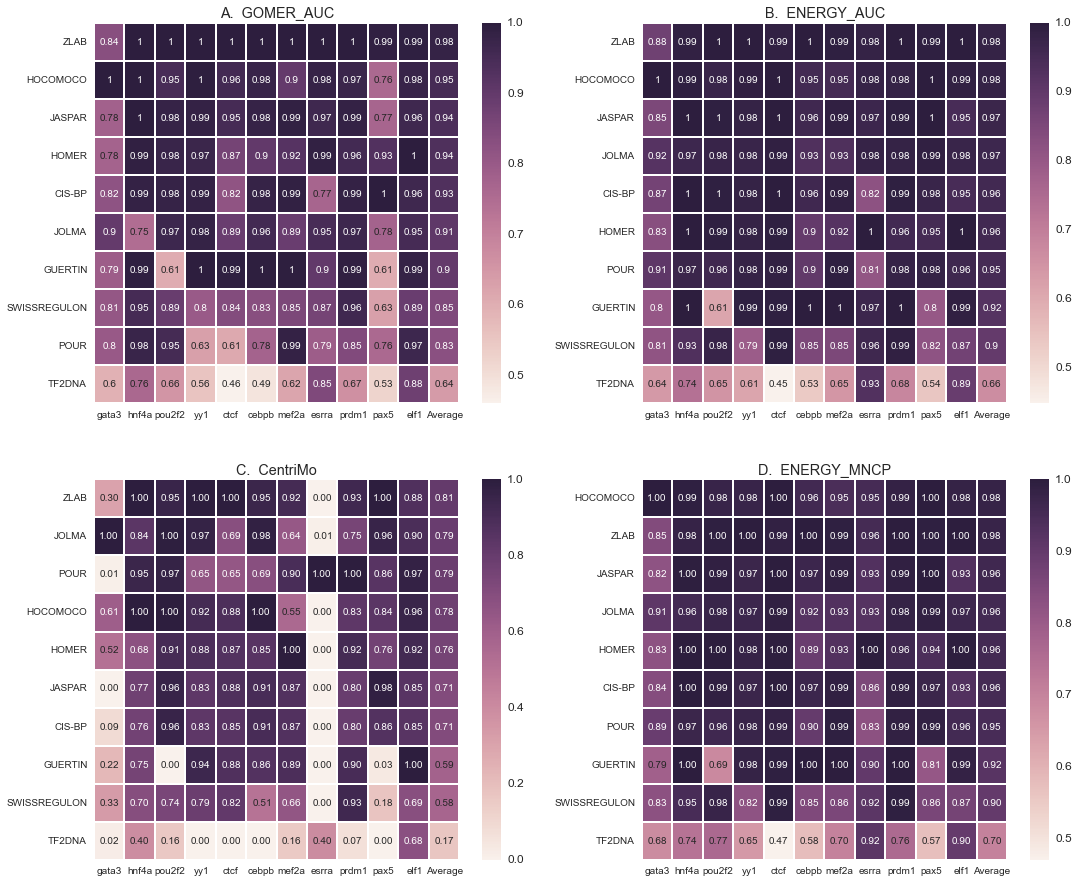

In [6]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 15), sharex=False, sharey=False)
i=1
sns.set(font_scale=1.2)
stat = 'auc'
score = 'gomer'
axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")
tf_list = "esrra hnf4a pou2f2 ".split()
tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('A.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

stat = 'auc'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")

#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('B.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Centrimo_collection.txt', index_col="Motif")


#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T


new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi), fmt='.2f')
eval(axi).set_title('C.  CentriMo')
i+=1


stat = 'mncp'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")

#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi), fmt='.2f')
eval(axi).set_title('D.  '+score.upper()+"_"+stat.upper())

#f.savefig('../Figures/Figure9_motif_database_ranks_normalized.pdf', bbox_inches='tight')

# Re-creation of the figure using Di-nucleaotide shuffle sequences scores

## Effect of scoring functions

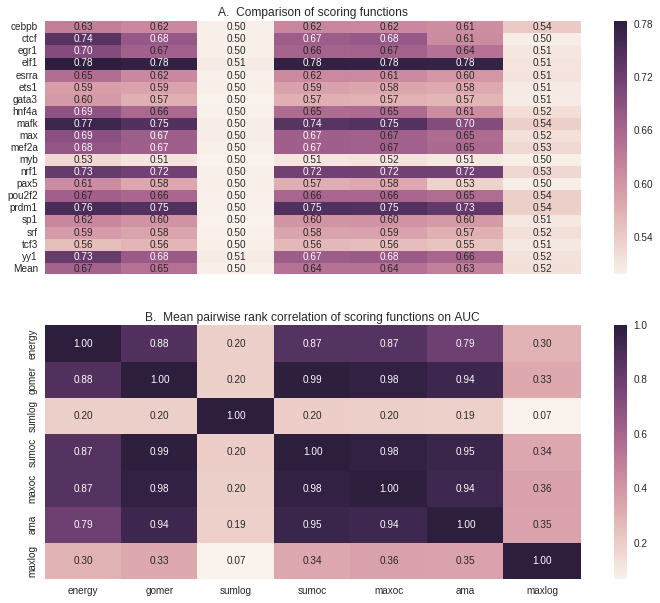

In [5]:
stat='auc'
tf_list="cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
#fig, ax = plt.subplots()
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("A.  Comparison of scoring functions")



tf = 'ctcf'
stat = 'auc'
mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list ="cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "gata3 hnf4a mafk max myb pou2f2 tcf3".split()
for tf in tf_list:
    mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on AUC")
f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc_new.pdf', bbox_inches='tight')

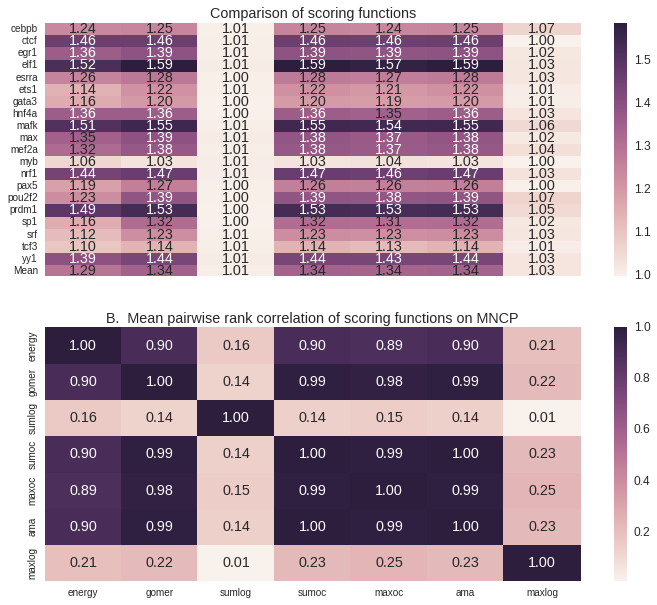

In [6]:
stat='mncp'
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#fig, ax = plt.subplots()

sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc  ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("Comparison of scoring functions")

tf = 'ctcf'
stat = 'mncp'
mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list = "cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
for tf in tf_list:
    mot_score =pd.read_table("../Dinuc_shuffled/Results/%s/%s_%s.rawscores" % (tf.capitalize(),tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on MNCP")
#f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc.pdf', bbox_inches='tight')
f=plt.gcf()
#f.savefig('../Figures/Figure7_effect_of_scoring_mncp_new.pdf', bbox_inches='tight')

## Correlating motif characteristics with scores

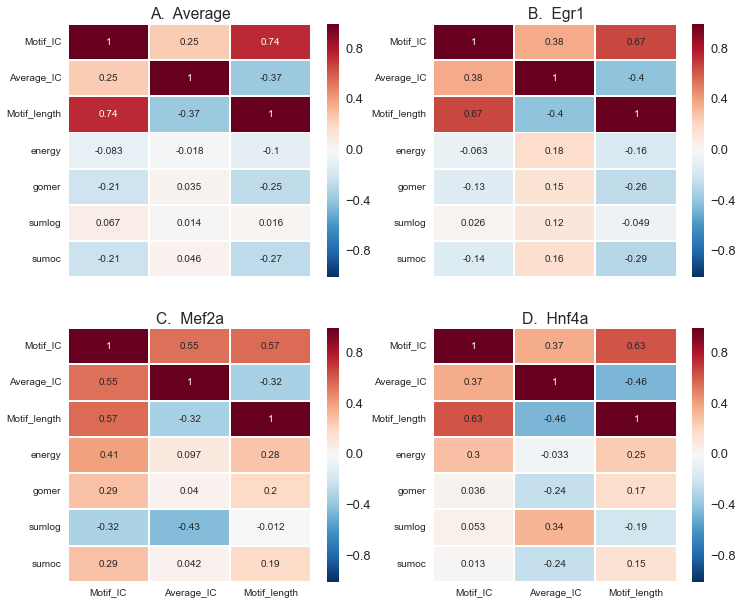

In [89]:
tf ='egr1' #initialize
stat = 'auc'
tf_list = "cebpb ctcf elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

tf_path = "%s/Dinuc_shuffled/Results/%s" % (BASE_DIR,tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
score_ic = df.corr()

for tf in tf_list:
    tf_path = "%s/Dinuc_shuffled/Results/%s" % (BASE_DIR,tf.capitalize())
    #df = tf+"_df"
    df1 = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf,stat), index_col="Motif_name")
    score_ic2 = df1.corr()
    score_ic = score_ic.add(score_ic2, fill_value=0)
test = score_ic/(len(tf_list)+1)

del test['energy']
del test['gomer']
del test['sumlog']
del test['sumoc']

test = test

path = "%s/Dinuc_shuffled/Results" % BASE_DIR

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=False)
sns.set(font_scale=1.3)
sns.heatmap(test, annot=True, ax = ax1)
ax1.set_title("A.  Average")

tf = "egr1"
tf_path = "%s/%s" % (path, tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax2)
ax2.set_title('B.  '+tf.capitalize())

tf = "mef2a"
tf_path = "%s/%s" % (path, tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax3)
ax3.set_title('C.  '+tf.capitalize())

tf = "hnf4a"
tf_path = "%s/%s" % (path, tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df
sns.heatmap(df, annot=True, ax = ax4)
ax4.set_title('D.  '+tf.capitalize())

#f.savefig('../Figures/Figure8_motif_length_ic_effect_minimal.pdf', bbox_inches='tight')

## Ranks of motif databases 

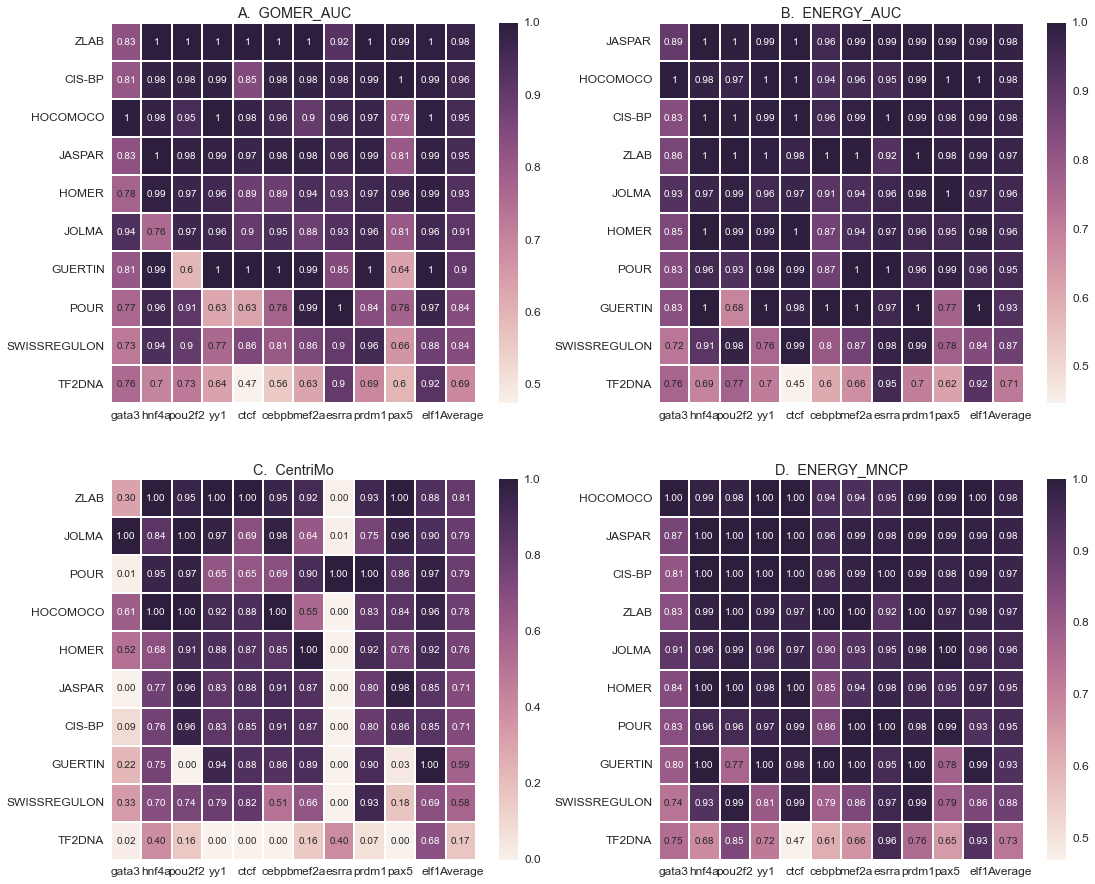

In [91]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 15), sharex=False, sharey=False)
i=1
sns.set(font_scale=1.2)
stat = 'auc'
score = 'gomer'
axi="ax"+str(i)
cent_col = pd.read_table('../Dinuc_shuffled/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")
tf_list = "esrra hnf4a pou2f2 ".split()
tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('A.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

stat = 'auc'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('../Dinuc_shuffled/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")

#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('B.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

axi="ax"+str(i)
cent_col = pd.read_table('../ChIP_seq/Results/Centrimo_collection.txt', index_col="Motif")


#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T


new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi), fmt='.2f')
eval(axi).set_title('C.  CentriMo')
i+=1


stat = 'mncp'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('../Dinuc_shuffled/Results/Db_ranks_%s_%s.txt' % (score, stat), index_col="Motif")

#tf_list=["hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf = "gata3" 
a = cent_col.T[tf]/max(cent_col.T[tf])
d = a.to_frame().T
for tf in tf_list:
    a = cent_col.T[tf]/max(cent_col.T[tf])
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi), fmt='.2f')
eval(axi).set_title('D.  '+score.upper()+"_"+stat.upper())

#f.savefig('../Figures/Figure9_motif_database_ranks_normalized.pdf', bbox_inches='tight')

## remove these later

In [ ]:
def rc_pwm(area_pwm, pwm_len):
    """
    Takes as input the forward pwm and returns a reverse
    complement of the motif
    """

    rcareapwm = {}
    rcareapwm["A"] = []
    rcareapwm["C"] = []
    rcareapwm["G"] = []
    rcareapwm["T"] = []
    rcareapwm["N"] = []
    for i in range(pwm_len):
        rcareapwm["A"].append(area_pwm["T"][pwm_len - i - 1])
        rcareapwm["C"].append(area_pwm["G"][pwm_len - i - 1])
        rcareapwm["G"].append(area_pwm["C"][pwm_len - i - 1])
        rcareapwm["T"].append(area_pwm["A"][pwm_len - i - 1])
        rcareapwm["N"].append(0.0)
    return rcareapwm


def get_motif(meme, motif="MOTIF"):
    """
    Extract a motif from meme file given a unique motif
    name and create dictionary for sequence scoring

    Default motif name is keyword MOTIF for single motif files. 
    """

    pwm_dictionary = {}
    pwm_dictionary["A"] = []
    pwm_dictionary["C"] = []
    pwm_dictionary["G"] = []
    pwm_dictionary["T"] = []
    pwm_dictionary["N"] = []
    flag = 0
    check = 0
    with open(meme, "r") as f1:
        for line in f1:
            if str(motif) in line:
                flag += 1
            if "letter-probability" in line and flag == 1:
                w = line.split(" ")[5]
                flag += 1
                continue
            if flag == 2 and int(check) < int(w):
                if line == "\n":
                    continue
                else:
                    words = line.split()
                    pwm_dictionary["A"].append(float(words[0]))
                    pwm_dictionary["C"].append(float(words[1]))
                    pwm_dictionary["G"].append(float(words[2]))
                    pwm_dictionary["T"].append(float(words[3]))
                    pwm_dictionary["N"].append(0.0)
                    check += 1
        return pwm_dictionary

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Sequence scoring  in parallel  
def score_from_genome(bed_df):
    
    return bed_df.apply(lambda row: fetch_and_score_seq(row[0], row[1], row[2]), axis=1)

def fetch_and_score_seq(contig, start, end):
    genome = pysam.FastaFile('/home/kipkurui/Dream_challenge/annotations/hg19.genome.fa')
    return score_function(pwm_dictionary, genome.fetch(contig, start, end).upper())



def energyscore(pwm_dictionary, seq):
    """
    Score sequences using the beeml energy scoring approach.

    Borrowed greatly from the work of Zhao and Stormo

    P(Si)=1/(1+e^Ei-u)

    Ei=sumsum(Si(b,k)e(b,k))

    Previous approaches seem to be using the the minimum sum of the
    energy contribution of each of the bases of a specific region.

    This is currently showing some promise but further testing is
    needed to ensure that I have a robust algorithm.
    """
    
    energy_list = []
    pwm_length = len(pwm_dictionary["A"])
    pwm_dictionary_rc = rc_pwm(pwm_dictionary, pwm_length)
    for i in range(len(seq) - 1):
        energy = 0
        energy_rc = 0
        for j in range(pwm_length - 1):
            if (j + i) >= len(seq):
                energy += 0.25
                energy_rc += 0.25
            else:
                energy += pwm_dictionary[seq[j + i]][j]
                energy_rc += pwm_dictionary_rc[seq[j + i]][j]

            energy_list.append(1 / (1 + (exp(energy))))
            energy_list.append(1 / (1 + (exp(energy_rc))))
    energy_score = min(energy_list)
    return energy_score

def compute_auc(predicted, cutoff, label):
    """
    Compute Area under ROC curve given a prediction file formatted as floows:
        seq_name                \t Score           \t Classification \n
        chr2:43019807-43019857	\t 4.251985e-06	\t 1 \n
        . \n
        . \n
        . \n
        chr2:43619807-43619857	\t 4.251985e-08	\t 0 \n
    log: Changed to be able to compute AUC for any scores
    """
    y = np.concatenate((np.ones(cutoff), np.zeros(cutoff)), axis=0)

    fpr, tpr, thresholds = metrics.roc_curve(y, predicted[:cutoff*2], pos_label=label)

    auc = metrics.auc(fpr, tpr)

    return auc

def compute_mncp(predicted, cutoff, label):
    """
    This is the MNCP computation adopted from Clarke 2003

    MNCP is a rank based metric similar to AUC but 
    its a plot of TP and all positives
    hence considered to be less affected by false positives.

    MNCP is the mean normalized
    """
    from numpy import mean, array, hstack
    if label == 1:
        fg_vals = predicted[:cutoff]
        bg_vals = predicted[cutoff:]
    else:
        fg_vals = predicted[cutoff:]
        bg_vals = predicted[:cutoff]
    fg_len = len(fg_vals)
    total_len = len(fg_vals) + len(bg_vals)

    if type(fg_vals) != type(array([])):
        fg_vals = array(fg_vals)
    if type(bg_vals) != type(array([])):
        bg_vals = array(bg_vals)
    # Rank the data
    fg_rank = stats.rankdata(fg_vals)

    # combine foreground and background data and get the ranks
    total_rank = stats.rankdata(hstack((fg_vals, bg_vals)))
    slopes = []
    for i in range(len(fg_vals)):
        slope = ((fg_len - fg_rank[i] + 1) / fg_len) / ((total_len - total_rank[i] + 1) / total_len)
        slopes.append(slope)
    mncp = mean(slopes)
    return mncp

In [ ]:
def get_bed_from_peaks(peak, width):
    """
    Given a bed file, extract the fasta in tab format and eliminate the masked sequences,
    and extract the negative version of the file
    
    """
    #Read the narrow peak file into a pandas DataFrame
    
    peak_file = pd.read_table(peak, header=None)[[0,1,2]]
    
    size = peak_file.count()[0]
    print size
    #Lets widden the coordinates to 100bp centered around the center
    mid = (peak_file[2] + peak_file[1])/2
    peak_file[1] = (mid - width/2+0.5).apply(int)
    peak_file[2]  = (mid + width/2+0.5).apply(int)
    
    #Extract the negative set located 500bp downstream
    #neg_bed = peak_file.copy(deep=True)
    
    #neg_bed[1] = neg_bed[1]+downstream_distance
    #neg_bed[2] = neg_bed[2]+downstream_distance
    
    # Eliminate repeat masked regions from the bed file
    peak_file = remove_repeats(peak_file) #.to_csv(pos_bed_out, index=None, header=None, sep="\t")
    #neg_bed = remove_repeats(neg_bed) #.to_csv(neg_bed_out, index=None, header=None, sep="\t")
    
    #hg = "/home/kipkurui/Project/MAT_server/Data/hg19.fa"
    return peak_file
    #pybedtools.BedTool.from_dataframe(peak_file).sequence(fi=hg,).save_seqs(negfa_out)